In [1]:
# Imports
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection, preprocessing


In [2]:
# Load data

feature = pd.read_csv('fish_market_feature.csv')
label = pd.read_csv('fish_market_label.csv')

x = feature.values
y = label.values

print(f"{x.shape = }, {y.shape = }")

x.shape = (124, 5), y.shape = (124, 1)


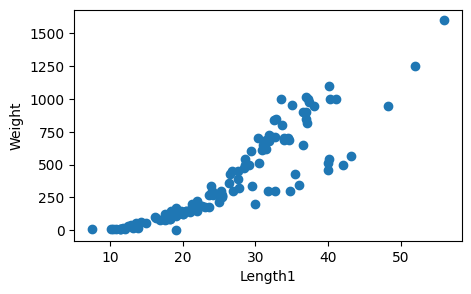

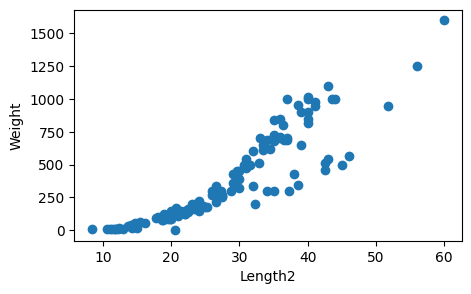

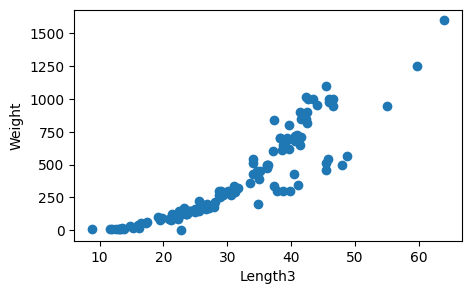

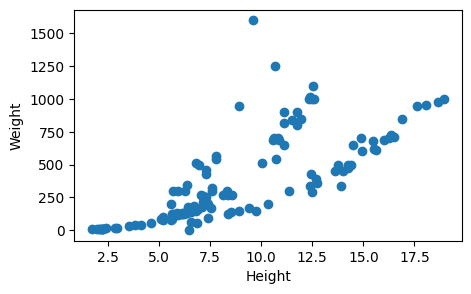

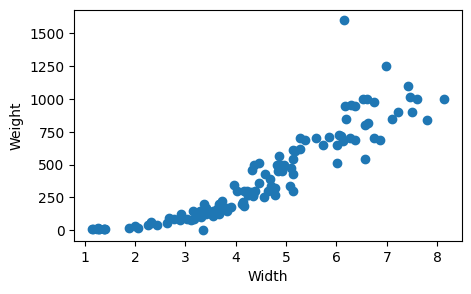

In [3]:
# Plot each feature

for column_name in feature.columns:
    plt.figure(figsize=(5, 3))
    plt.plot(feature[column_name], label['Weight'], 'o')
    plt.xlabel(column_name)
    plt.ylabel('Weight')
    plt.show()


In [4]:
normalizer = partial(preprocessing.scale, with_mean=False)

x_train, x_val, y_train, y_val = map(
    normalizer,
    model_selection.train_test_split(x, y, test_size=0.1, random_state=48),
)


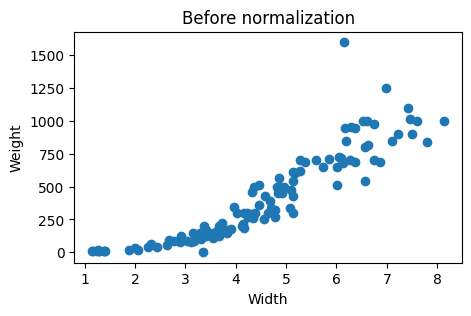

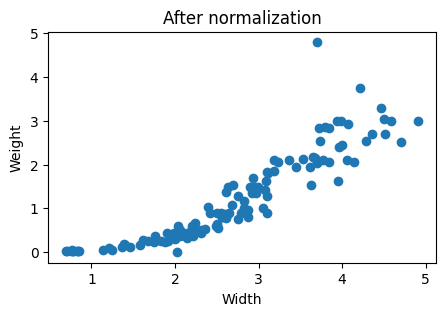

In [5]:
# Graph for before/after normalization
x_before = feature['Width']
x_after = normalizer(x_before)
y_before = label['Weight']
y_after = normalizer(y_before)

# Before
plt.figure(figsize=(5, 3))
plt.plot(x_before, y_before, 'o')
plt.xlabel('Width')
plt.ylabel('Weight')
plt.title('Before normalization')
plt.show()

# After
plt.figure(figsize=(5, 3))
plt.plot(x_after, y_after, 'o')
plt.xlabel('Width')
plt.ylabel('Weight')
plt.title('After normalization')
plt.show()

In [6]:
def design_matrix(x, order=1):
    return np.hstack(x[None, :, :] ** np.arange(1, order+1)[:, None, None])
    # return np.hstack([
    #     np.ones((x.shape[0], 1)),  # Bias
    #     *(x[None, :, :] ** np.arange(1, order+1)[:, None, None]),
    # ])


In [7]:
# Helper for running a model
def run_model(model, m=1, **kwargs):
    x_d_train = design_matrix(x_train, order=m)
    x_d_val = design_matrix(x_val, order=m)

    reg = model(fit_intercept=True, **kwargs)

    reg.fit(x_d_train, y_train)

    yhat_train = reg.predict(x_d_train)
    mse_train = ((y_train - yhat_train) ** 2).mean()

    yhat_val = reg.predict(x_d_val)
    mse_val = ((y_val - yhat_val) ** 2).mean()

    return mse_train, mse_val


In [8]:
# Find the optimal regression type
def test_model(model, **kwargs):
    mse_train, mse_val = run_model(model, **kwargs)
    print(f"{model.__name__: <18}: {mse_train = : <4.3f}, {mse_val = :<4.3f}")

test_model(linear_model.LinearRegression)
test_model(linear_model.Lasso, alpha=0.05)  # Not good
test_model(linear_model.Ridge, alpha=0.05)


LinearRegression  : mse_train = 0.119, mse_val = 0.118
Lasso             : mse_train = 1.779, mse_val = 1.876
Ridge             : mse_train = 0.119, mse_val = 0.123


Lasso regularization yielded bad loss. Since results from LinearRegression can be simulated with Ridge with `alpha = 0`, we decided to continue with just `Ridge` instead.

/Users/danielgu/Library/Caches/pypoetry/virtualenvs/nyu2023summerml1-PUBzEmvh-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.99216e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/danielgu/Library/Caches/pypoetry/virtualenvs/nyu2023summerml1-PUBzEmvh-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.46948e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/danielgu/Library/Caches/pypoetry/virtualenvs/nyu2023summerml1-PUBzEmvh-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.41247e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/danielgu/Library/Caches/pypoetry/virtualenvs/nyu2023summerml1-PUBzEmvh-py3.10/lib/pytho

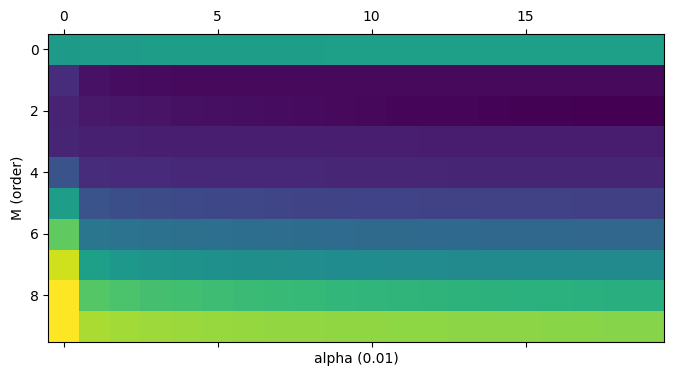

In [9]:
# Plot the performance of different M and alpha values

M_values = np.arange(1, 11)
alpha_values = np.linspace(0, 0.2, 20)

grid = np.empty((M_values.size, alpha_values.size))

for i, M in enumerate(M_values):
    for j, alpha in enumerate(alpha_values):
        grid[i, j] = run_model(linear_model.Ridge, M, alpha=alpha)[1]

plt.figure(figsize=(8, 4))
plt.matshow(np.log(grid), fignum=0)
plt.xlabel('alpha (0.01)')
plt.ylabel('M (order)')
plt.show()

The alpha doesn't seem to have much of an effect for `M` smaller than 6-7.

The optimal M value is around 3-5, so we will continue with `M=3` and `alpha=0.05`

In [10]:
# Create the final regression

x_d_train = design_matrix(x_train, order=3)
x_d_val = design_matrix(x_val, order=3)

reg = linear_model.Ridge(fit_intercept=True, alpha=0.05)

reg.fit(x_d_train, y_train)

yhat_train = reg.predict(x_d_train)
mse_train = ((y_train - yhat_train) ** 2).mean()

yhat_val = reg.predict(x_d_val)
mse_val = ((y_val - yhat_val) ** 2).mean()

print("Final regression")
print(f"Training MSE:   {mse_train:.5f}")
print(f"Validation MSE: {mse_val:.5f}")


Final regression
Training MSE:   0.01844
Validation MSE: 0.02757


In [11]:
# Load & normalize test data

feature = pd.read_csv('fish_market_test_feature.csv')
label = pd.read_csv('fish_market_test_label.csv')

x_test = normalizer(feature.values)
y_test_normalizer = preprocessing.StandardScaler(with_mean=False)
y_test = y_test_normalizer.fit_transform(label.values)


In [12]:
x_d_test = design_matrix(x_test, order=3)
yhat_test = reg.predict(x_d_test)

# Denormalize data
actual = label.values
predicted = y_test_normalizer.inverse_transform(yhat_test)


df = pd.DataFrame({'Actual': actual[:, 0], 'Predicted': predicted[:, 0]})
df = df.sort_values(by='Predicted')


Final MSE: 3519.7 (RMSE 59.3)


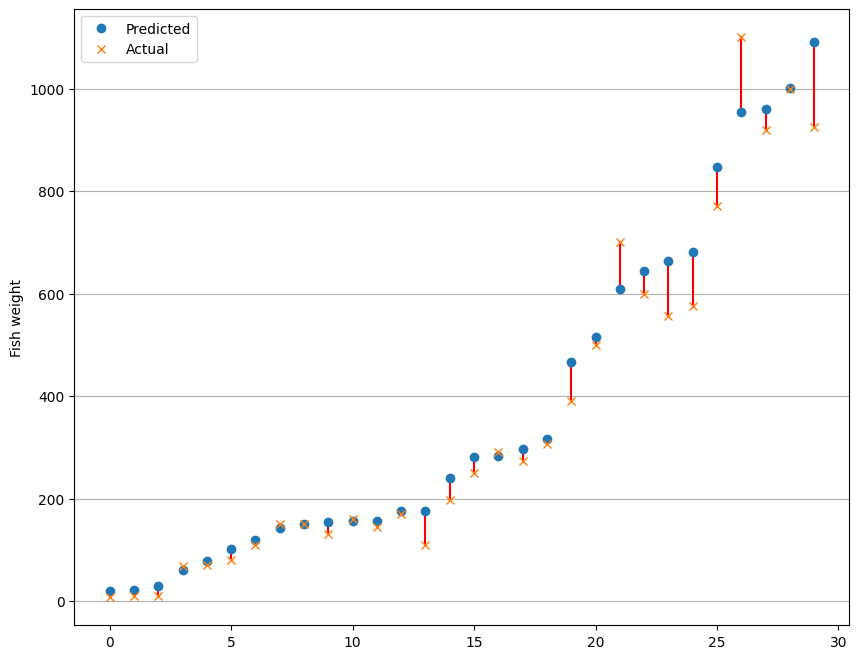

In [17]:
mse = ((df['Actual'] - df['Predicted']) ** 2).mean()
print(f"Final MSE: {mse:.5} (RMSE {np.sqrt(mse):.3})")

xplt = np.arange(len(df))

plt.figure(figsize=(10, 8))
plt.plot([xplt, xplt], df.values.T, 'r-')
plt.plot(xplt, df['Predicted'], 'o', label='Predicted')
plt.plot(xplt, df['Actual'], 'x', label='Actual')
plt.ylabel('Fish weight')
plt.grid(axis='y')
plt.legend()
plt.show()
